In [1]:
import numpy as np
import pandas as pd
import os

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from scipy.special import rel_entr
from scipy.stats import entropy
import scipy.stats
import math
import warnings 
warnings.filterwarnings("ignore") 

In [2]:
# 使用GPU
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [3]:
! nvidia-smi

Sun Mar 27 15:26:56 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.103.01   Driver Version: 470.103.01   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| 51%   60C    P2    77W / 260W |   2287MiB / 11019MiB |     20%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:02:00.0 Off |                  N/A |
| 29%   

# Company數量

In [4]:
from pymongo import MongoClient
import pymongo

In [5]:
mongoURI = "mongodb://%s:%s@%s/%s?authMechanism=SCRAM-SHA-1" % ("eva", "eva_30241", "140.117.69.70:30241", "eva")

try:
    conn = pymongo.MongoClient(mongoURI)
    db = conn.eva
    db_de = db.patent_de
    db_us = db.patent_us
    db_cn = db.patent_cn
except errors.ConnectionFailure as err:
    print(err)

In [6]:
data_assignee = db_de.aggregate([
    {"$unwind" : "$current_assignee"},
    {"$group" : {"_id" : "$current_assignee", "count":{"$sum":1}}},
    {"$sort": {"count":-1}},
    {"$limit":30}
])

ls_company = []
ls_count = []
for data in data_assignee:
    # print(data["_id"],data["count"])
    ls_company.append(data["_id"])
    ls_count.append(data["count"])

In [7]:
df_family_de = pd.DataFrame((zip(ls_company, ls_count)), columns = ['company', 'count'])

In [8]:
data_assignee = db_cn.aggregate([
    {"$unwind" : "$current_assignee"},
    {"$group" : {"_id" : "$current_assignee", "count":{"$sum":1}}},
    {"$sort": {"count":-1}},
    {"$limit":30}
])

ls_company = []
ls_count = []
for data in data_assignee:
    # print(data["_id"],data["count"])
    ls_company.append(data["_id"])
    ls_count.append(data["count"])
    
df_family_cn = pd.DataFrame((zip(ls_company, ls_count)), columns = ['company', 'count'])

In [9]:
data_assignee = db_us.aggregate([
    {"$unwind" : "$current_assignee"},
    {"$group" : {"_id" : "$current_assignee", "count":{"$sum":1}}},
    {"$sort": {"count":-1}},
    {"$limit":30}
])

ls_company = []
ls_count = []
for data in data_assignee:
    # print(data["_id"],data["count"])
    ls_company.append(data["_id"])
    ls_count.append(data["count"])
    
df_family_us = pd.DataFrame((zip(ls_company, ls_count)), columns = ['company', 'count'])

In [10]:
final_df = pd.concat([df_family_de,df_family_cn,df_family_us],axis=0)

In [12]:
# 取總數前15家公司
final_df.groupby("company").sum().reset_index().sort_values("count",ascending=False).head(15)

,company,count
45,Qualcomm Inc,8491
49,Samsung Electronics Co Ltd,6337
28,Intel Corp,3236
61,Telefonaktiebolaget LM Ericsson AB,2488
24,Huawei Technologies Co Ltd,2461
33,LG Electronics Inc,1931
30,International Business Machines Corp,1591
2,Apple Inc,1104
9,Cisco Technology Inc,1092
36,Microsoft Technology Licensing LLC,963


In [21]:
com_df = final_df.groupby("company").sum().reset_index().sort_values("count",ascending=False).head(15)

In [22]:
com_df.reset_index(drop=True, inplace=True)

In [23]:
# com_ls = list(final_df.groupby("company").sum().reset_index().sort_values("count",ascending=False).head(15)["company"])
# com_ls

['Qualcomm Inc',
 'Samsung Electronics Co Ltd',
 'Intel Corp',
 'Telefonaktiebolaget LM Ericsson AB',
 'Huawei Technologies Co Ltd',
 'LG Electronics Inc',
 'International Business Machines Corp',
 'Apple Inc',
 'Cisco Technology Inc',
 'Microsoft Technology Licensing LLC',
 'Micron Technology Inc',
 'Sony Corp',
 'Nokia Technologies Oy',
 'Shenzhen Shenglu IoT Communication Technology Co Ltd',
 'NTT Docomo Inc']

In [24]:
# com_ls=['Qualcomm Inc', 'Samsung Electronics Co Ltd', 'Intel Corp', 'Telefonaktiebolaget LM Ericsson AB', 'Huawei Technologies Co Ltd', 'LG Electronics Inc', 'International Business Machines Corp', 'Apple Inc', 'Cisco Technology Inc', 'Microsoft Technology Licensing LLC', 'Micron Technology Inc', 'Sony Corp', 'Nokia Technologies Oy', 'Shenzhen Shenglu IoT Communication Technology Co Ltd', 'NTT Docomo Inc']

In [25]:
# com_count = [8491,6337,3236,2488,2461,1931,1591,1104,1092,963,731,711,668,656,612]

In [26]:
# com_df = pd.DataFrame((zip(com_ls, com_count)), columns = ['company', 'count'])

In [27]:
com_df["count_log"] = com_df["count"].apply(lambda x: np.log(x))

In [28]:
com_df

,company,count,count_log
0,Qualcomm Inc,8491,9.046762
1,Samsung Electronics Co Ltd,6337,8.754161
2,Intel Corp,3236,8.082093
3,Telefonaktiebolaget LM Ericsson AB,2488,7.819234
4,Huawei Technologies Co Ltd,2461,7.808323
5,LG Electronics Inc,1931,7.565793
6,International Business Machines Corp,1591,7.372118
7,Apple Inc,1104,7.006695
8,Cisco Technology Inc,1092,6.995766
9,Microsoft Technology Licensing LLC,963,6.870053


In [34]:
com_ls = list(com_df.company)

# Data

In [29]:
ccontry = pd.read_csv("./final_data/company_country_all.csv")

In [30]:
ccpc = pd.read_csv("./final_data/company_cpc_all.csv")

In [35]:
ccontry[ccontry.company.isin(com_ls)].head()

,company,AP,AR,AT,AU,BE,BG,BR,CA,CH,...,SI,SM,TN,TR,TW,UA,US,UY,WO,ZA
716,Apple Inc,0.0,0.0,0.0,8.0,0.0,0.0,18.0,2.0,0.0,...,0.0,0.0,0.0,0.0,62.0,0.0,1045.0,0.0,1013.0,0.0
2958,Cisco Technology Inc,0.0,0.0,0.0,13.0,0.0,0.0,0.0,54.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1160.0,0.0,326.0,0.0
6392,Huawei Technologies Co Ltd,0.0,2.0,0.0,75.0,0.0,0.0,204.0,81.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1341.0,0.0,2117.0,4.0
6965,Intel Corp,0.0,0.0,0.0,9.0,0.0,0.0,60.0,4.0,0.0,...,0.0,0.0,0.0,0.0,167.0,0.0,3254.0,0.0,1546.0,0.0
7007,International Business Machines Corp,0.0,0.0,0.0,1.0,0.0,0.0,2.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1687.0,0.0,142.0,2.0


# Similarity計算

## Country

- 換成機率  
- 比例vs機率(?)  

[KL](https://datascience.stackexchange.com/questions/9262/calculating-kl-divergence-in-python)  
[KL neg](https://stats.stackexchange.com/questions/41297/kullback-leibler-divergence-negative-values)

In [36]:
ccontry.set_index("company", inplace=True)
ccontry2 = ccontry.apply(lambda x: x/sum(x), axis=1) #比例 row(axis=1)加總為1

In [41]:
P = ccontry2[ccontry2.index==com_ls[0]].values.tolist()[0][1:]
Q = ccontry2[ccontry2.index==com_ls[1]].values.tolist()[0][1:]

In [11]:
# print(P)
# print(Q)

[0.00039672419167445944, 0.0, 0.014962169514579614, 0.0, 0.0, 0.037632123324548725, 0.01507551928362946, 0.0, 0.0016152342089602993, 0.1511235795857066, 0.0018419337470599903, 0.0, 0.0, 0.0, 0.0, 5.667488452492278e-05, 0.00036838674941199807, 0.0, 0.00022669953809969113, 5.667488452492278e-05, 0.13766329451103743, 0.00467567797330613, 0.0, 0.0, 5.667488452492278e-05, 0.0, 0.0, 0.0003117118648870753, 5.667488452492278e-05, 0.001671909093485222, 0.0, 0.0010768228059735328, 0.0002833744226246139, 0.0, 0.0, 0.037632123324548725, 0.04582164413840007, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0009634730369236873, 0.0, 0.0, 0.0, 0.00014168721131230694, 0.0, 0.0012751849018107625, 0.00011334976904984556, 0.00014168721131230694, 0.0, 5.667488452492278e-05, 0.0013601972285981468, 0.00011334976904984556, 0.0, 0.025163648729065714, 0.0003400493071495367, 0.0, 0.00022669953809969113, 0.0, 0.06101051319107937, 0.0, 0.2364759556802403, 0.0, 0.21953016520728838, 0.00048173651846184363]
[0.0, 0.0, 0.00618062563067608

### KL Divergence

In [37]:
def KL(a, b):
    a = np.asarray(a, dtype=np.float64)
    b = np.asarray(b, dtype=np.float64)
    
    mylist = np.asarray(a) / np.asarray(b)
    mylist = [0 if math.isnan(x) else x for x in mylist]
    mylist = [0 if np.isinf(x) else x for x in mylist]
    mylist = [0 if np.isneginf(x) else x for x in np.log(mylist)]
    mylist = np.sum(a*np.asarray(mylist))

    return mylist

In [42]:
mylist = np.asarray(P) / np.asarray(Q)
mylist = [0 if math.isnan(x) else x for x in mylist]
mylist = [0 if np.isinf(x) else x for x in mylist]
mylist = [0 if np.isneginf(x) else x for x in np.log(mylist)]
mylist = np.sum(P*np.asarray(mylist))
mylist

0.41924802435001735

In [43]:
np.log(mylist)

-0.8692925906333511

In [44]:
sum(ccontry2.loc["#glowontech",:])

1.0

- 計算Qualcomm Inc和其他公司的相似程度

In [45]:
ccontry3 = ccontry2.copy()

In [46]:
ccontry3["KL"] = ccontry3.apply(lambda x: KL(ccontry3.loc["Qualcomm Inc",:],x), axis=1)

In [47]:
ccontry3.sort_values(["KL"],ascending=True)

,AP,AR,AT,AU,BE,BG,BR,CA,CH,CL,...,SM,TN,TR,TW,UA,US,UY,WO,ZA,KL
company,,,,,,,,,,,,,,,,,,,,,
Verisign Inc,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.619048,0.000000,0.000000,0.000000,-0.367692
American Megatrends International LLC,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.600000,0.000000,0.000000,0.000000,-0.367277
Stichting Imec Nederland,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.600000,0.000000,0.000000,0.000000,-0.367018
Textron Innovations Inc,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.600000,0.000000,0.000000,0.000000,-0.367018
Mojio Inc,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.666667,0.000000,0.000000,0.000000,-0.366834
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Theravance Biopharma Antibiotics IP LLC,0.000000,0.031250,0.0,0.031250,0.0,0.0,0.031250,0.031250,0.0,0.000000,...,0.000000,0.0,0.0,0.031250,0.031250,0.031250,0.000000,0.031250,0.031250,1.357324
Gilead Sciences Inc,0.027778,0.027778,0.0,0.027778,0.0,0.0,0.027778,0.027778,0.0,0.027778,...,0.027778,0.0,0.0,0.027778,0.027778,0.027778,0.027778,0.027778,0.027778,1.469164
Zhuhai Youte IoT Technology Co Ltd,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.009901,0.000000,0.009901,0.000000,1.635587


### PCB
- 和Qualcomm Inc比較
- η怎麼調整(?)

In [134]:
ccontry_pcb = ccontry2.loc[com_ls,:].copy()
ccontry_pcb

,AP,AR,AT,AU,BE,BG,BR,CA,CH,CL,...,SI,SM,TN,TR,TW,UA,US,UY,WO,ZA
company,,,,,,,,,,,,,,,,,,,,,
Qualcomm Inc,0.000000,0.000397,0.0,0.014962,0.0,0.0,0.037632,0.015076,0.0,0.001615,...,0.00034,0.0,0.000227,0.00000,0.061011,0.0,0.236476,0.0,0.219530,0.000482
Samsung Electronics Co Ltd,0.000000,0.000000,0.0,0.006181,0.0,0.0,0.000378,0.001430,0.0,0.000000,...,0.00000,0.0,0.000000,0.00000,0.009124,0.0,0.259628,0.0,0.144551,0.000000
Intel Corp,0.000000,0.000000,0.0,0.001009,0.0,0.0,0.006723,0.000448,0.0,0.000000,...,0.00000,0.0,0.000000,0.00000,0.018714,0.0,0.364635,0.0,0.173241,0.000000
Telefonaktiebolaget LM Ericsson AB,0.000166,0.015076,0.0,0.011266,0.0,0.0,0.028827,0.011597,0.0,0.001740,...,0.00000,0.0,0.000000,0.00058,0.005053,0.0,0.193091,0.0,0.201789,0.011514
Huawei Technologies Co Ltd,0.000000,0.000249,0.0,0.009330,0.0,0.0,0.025376,0.010076,0.0,0.000000,...,0.00000,0.0,0.000000,0.00000,0.000000,0.0,0.166812,0.0,0.263341,0.000498
LG Electronics Inc,0.000000,0.000169,0.0,0.005237,0.0,0.0,0.004224,0.002703,0.0,0.002027,...,0.00000,0.0,0.000000,0.00000,0.001689,0.0,0.314073,0.0,0.218618,0.000169
International Business Machines Corp,0.000000,0.000000,0.0,0.000433,0.0,0.0,0.000867,0.000433,0.0,0.000000,...,0.00000,0.0,0.000000,0.00000,0.000000,0.0,0.730936,0.0,0.061525,0.000867
Apple Inc,0.000000,0.000000,0.0,0.001978,0.0,0.0,0.004450,0.000494,0.0,0.000000,...,0.00000,0.0,0.000000,0.00000,0.015328,0.0,0.258344,0.0,0.250433,0.000000
Cisco Technology Inc,0.000000,0.000000,0.0,0.006523,0.0,0.0,0.000000,0.027095,0.0,0.000000,...,0.00000,0.0,0.000000,0.00000,0.000000,0.0,0.582037,0.0,0.163573,0.000000


In [135]:
def PCB(a,b):
    return sum(a*b)

ccontry_pcb["sum"] = ccontry_pcb.apply(lambda x: PCB(ccontry_pcb.loc["Qualcomm Inc",:],x), axis=1)

###### n

In [136]:
pcb_ls=[]
n=0.3

for i in ccontry_pcb.index:
    pcb = ccontry_pcb.loc[[i],:]["sum"].values+n*((com_df.count_log[com_df.company=="Qualcomm Inc"].values-com_df.count_log[com_df.company==i].values)**2)
    pcb_ls.append(pcb[0])
    
ccontry_pcb["pcb"]=pcb_ls

In [137]:
ccontry_pcb.sort_values(["pcb"],ascending=True)

,AP,AR,AT,AU,BE,BG,BR,CA,CH,CL,...,TN,TR,TW,UA,US,UY,WO,ZA,sum,pcb
company,,,,,,,,,,,,,,,,,,,,,
Qualcomm Inc,0.000000,0.000397,0.0,0.014962,0.0,0.0,0.037632,0.015076,0.0,0.001615,...,0.000227,0.00000,0.061011,0.0,0.236476,0.0,0.219530,0.000482,0.155680,0.155680
Samsung Electronics Co Ltd,0.000000,0.000000,0.0,0.006181,0.0,0.0,0.000378,0.001430,0.0,0.000000,...,0.000000,0.00000,0.009124,0.0,0.259628,0.0,0.144551,0.000000,0.151404,0.177089
Intel Corp,0.000000,0.000000,0.0,0.001009,0.0,0.0,0.006723,0.000448,0.0,0.000000,...,0.000000,0.00000,0.018714,0.0,0.364635,0.0,0.173241,0.000000,0.165565,0.444741
Telefonaktiebolaget LM Ericsson AB,0.000166,0.015076,0.0,0.011266,0.0,0.0,0.028827,0.011597,0.0,0.001740,...,0.000000,0.00058,0.005053,0.0,0.193091,0.0,0.201789,0.011514,0.141935,0.593983
Huawei Technologies Co Ltd,0.000000,0.000249,0.0,0.009330,0.0,0.0,0.025376,0.010076,0.0,0.000000,...,0.000000,0.00000,0.000000,0.0,0.166812,0.0,0.263341,0.000498,0.167782,0.627901
LG Electronics Inc,0.000000,0.000169,0.0,0.005237,0.0,0.0,0.004224,0.002703,0.0,0.002027,...,0.000000,0.00000,0.001689,0.0,0.314073,0.0,0.218618,0.000169,0.163836,0.821816
International Business Machines Corp,0.000000,0.000000,0.0,0.000433,0.0,0.0,0.000867,0.000433,0.0,0.000000,...,0.000000,0.00000,0.000000,0.0,0.730936,0.0,0.061525,0.000867,0.201824,1.043154
Apple Inc,0.000000,0.000000,0.0,0.001978,0.0,0.0,0.004450,0.000494,0.0,0.000000,...,0.000000,0.00000,0.015328,0.0,0.258344,0.0,0.250433,0.000000,0.169731,1.418293
Cisco Technology Inc,0.000000,0.000000,0.0,0.006523,0.0,0.0,0.000000,0.027095,0.0,0.000000,...,0.000000,0.00000,0.000000,0.0,0.582037,0.0,0.163573,0.000000,0.204294,1.466269


## CPC

In [138]:
# ccpc.set_index("company", inplace=True)
ccpc2 = ccpc.apply(lambda x: x/sum(x), axis=1) #比例 row(axis=1)加總為1

In [139]:
ccpc_pcb = ccpc2.loc[com_ls,:].copy()
ccpc_pcb

,A01,A21,A22,A23,A24,A41,A42,A43,A44,A45,...,G16,G21,H01,H02,H03,H04,H05,Y02,Y04,Y10
company,,,,,,,,,,,,,,,,,,,,,
Qualcomm Inc,0.000000,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000011,0.000000,...,0.000207,0.0,0.027181,0.000976,0.017746,0.895970,0.001837,0.008356,0.000287,0.000000
Samsung Electronics Co Ltd,0.000000,0.0,0.0,0.000027,0.00000,0.000135,0.000014,0.000122,0.000243,0.000635,...,0.003837,0.0,0.061415,0.013321,0.015469,0.511531,0.012415,0.009308,0.000405,0.000230
Intel Corp,0.000427,0.0,0.0,0.000000,0.00000,0.000152,0.000000,0.000091,0.000000,0.000000,...,0.001219,0.0,0.108724,0.011915,0.013408,0.471676,0.007283,0.014596,0.001006,0.000061
Telefonaktiebolaget LM Ericsson AB,0.000000,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.001862,0.0,0.003385,0.000564,0.011566,0.919544,0.001016,0.012130,0.000621,0.000000
Huawei Technologies Co Ltd,0.000000,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.002042,0.0,0.007350,0.000817,0.013476,0.901762,0.000992,0.014409,0.000233,0.000000
LG Electronics Inc,0.000000,0.0,0.0,0.000000,0.00000,0.000000,0.000132,0.000044,0.000000,0.000175,...,0.001886,0.0,0.002325,0.001491,0.003334,0.618222,0.003115,0.008291,0.000307,0.000000
International Business Machines Corp,0.001758,0.0,0.0,0.000000,0.00007,0.000070,0.000000,0.000000,0.000000,0.000000,...,0.026586,0.0,0.078492,0.007455,0.002391,0.264594,0.001829,0.009917,0.002040,0.000141
Apple Inc,0.000000,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000181,0.0,0.002985,0.001357,0.004884,0.930361,0.000000,0.012119,0.000090,0.000000
Cisco Technology Inc,0.000000,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000406,0.0,0.004466,0.006597,0.001522,0.746575,0.003451,0.013701,0.004770,0.000101


In [141]:
def PCB(a,b):
    return sum(a*b)

ccpc_pcb["sum"] = ccpc_pcb.apply(lambda x: PCB(ccpc_pcb.loc["Qualcomm Inc",:],x), axis=1)

###### n

In [142]:
pcb_ls=[]
n=0.3

for i in ccpc_pcb.index:
    pcb = ccpc_pcb.loc[[i],:]["sum"].values+n*((com_df.count_log[com_df.company=="Qualcomm Inc"].values-com_df.count_log[com_df.company==i].values)**2)
    pcb_ls.append(pcb[0])
    
ccpc_pcb["pcb"]=pcb_ls

In [143]:
ccpc_pcb.sort_values(["pcb"],ascending=True)

,A01,A21,A22,A23,A24,A41,A42,A43,A44,A45,...,H01,H02,H03,H04,H05,Y02,Y04,Y10,sum,pcb
company,,,,,,,,,,,,,,,,,,,,,
Samsung Electronics Co Ltd,0.000000,0.0,0.0,0.000027,0.00000,0.000135,0.000014,0.000122,0.000243,0.000635,...,0.061415,0.013321,0.015469,0.511531,0.012415,0.009308,0.000405,0.000230,0.840408,0.866093
Intel Corp,0.000427,0.0,0.0,0.000000,0.00000,0.000152,0.000000,0.000091,0.000000,0.000000,...,0.108724,0.011915,0.013408,0.471676,0.007283,0.014596,0.001006,0.000061,0.780728,1.059903
International Business Machines Corp,0.001758,0.0,0.0,0.000000,0.00007,0.000070,0.000000,0.000000,0.000000,0.000000,...,0.078492,0.007455,0.002391,0.264594,0.001829,0.009917,0.002040,0.000141,0.450479,1.291809
Qualcomm Inc,0.000000,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000011,0.000000,...,0.027181,0.000976,0.017746,0.895970,0.001837,0.008356,0.000287,0.000000,1.451964,1.451964
LG Electronics Inc,0.000000,0.0,0.0,0.000000,0.00000,0.000000,0.000132,0.000044,0.000000,0.000175,...,0.002325,0.001491,0.003334,0.618222,0.003115,0.008291,0.000307,0.000000,1.005530,1.663511
Huawei Technologies Co Ltd,0.000000,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.007350,0.000817,0.013476,0.901762,0.000992,0.014409,0.000233,0.000000,1.460865,1.920985
Telefonaktiebolaget LM Ericsson AB,0.000000,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.003385,0.000564,0.011566,0.919544,0.001016,0.012130,0.000621,0.000000,1.488955,1.941003
Microsoft Technology Licensing LLC,0.000238,0.0,0.0,0.000000,0.00000,0.000476,0.000000,0.000000,0.000000,0.000238,...,0.010942,0.008206,0.002022,0.349429,0.001189,0.006185,0.000833,0.000000,0.587304,2.008722
Micron Technology Inc,0.000000,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.010240,0.000218,0.014815,0.111220,0.000000,0.009695,0.000218,0.000000,0.205946,2.010150


# Scatter Plot

In [144]:
c_df = pd.DataFrame((zip(list(ccpc_pcb["pcb"]), list(ccontry_pcb["pcb"]))), columns = ['cpc', 'country'])

In [145]:
c_df.set_index(ccpc_pcb.index, inplace=True)
c_df

,cpc,country
company,,
Qualcomm Inc,1.451964,0.155680
Samsung Electronics Co Ltd,0.866093,0.177089
Intel Corp,1.059903,0.444741
Telefonaktiebolaget LM Ericsson AB,1.941003,0.593983
Huawei Technologies Co Ltd,1.920985,0.627901
LG Electronics Inc,1.663511,0.821816
International Business Machines Corp,1.291809,1.043154
Apple Inc,2.754710,1.418293
Cisco Technology Inc,2.477247,1.466269


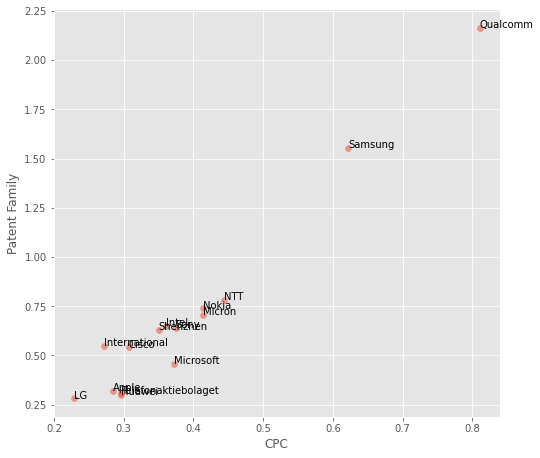

In [229]:
plt.figure(figsize=(8,7.5))
plt.style.use('ggplot')

plt.scatter(c_df.cpc, c_df.country, alpha=0.5)
plt.xlabel("CPC")
plt.ylabel("Patent Family")

for i, txt in enumerate(c_df.index):
    plt.text(c_df.cpc[i], c_df.country[i],txt.split(" ")[0])
    
plt.show()

# Scatter Plot 2
- IBM

In [230]:
ccontry_pcb_ibm = ccontry2.loc[com_ls,:].copy()
ccontry_pcb_ibm["sum"] = ccontry_pcb_ibm.apply(lambda x: PCB(ccontry_pcb_ibm.loc["International Business Machines Corp",:],x), axis=1)

In [263]:
pcb_ls=[]
n=0.2

for i in ccontry_pcb_ibm.index:
    pcb = ccontry_pcb_ibm.loc[[i],:]["sum"].values+n*((com_df.count_log[com_df.company=="International Business Machines Corp"].values-com_df.count_log[com_df.company==i].values)**2)
    pcb_ls.append(pcb[0])
    
ccontry_pcb_ibm["pcb"]=pcb_ls

In [264]:
ccpc_pcb_ibm = ccpc2.loc[com_ls,:].copy()
ccpc_pcb_ibm["sum"] = ccpc_pcb_ibm.apply(lambda x: PCB(ccpc_pcb_ibm.loc["International Business Machines Corp",:],x), axis=1)

In [269]:
pcb_ls=[]
n=0.3

for i in ccpc_pcb_ibm.index:
    pcb = ccpc_pcb_ibm.loc[[i],:]["sum"].values+n*((com_df.count_log[com_df.company=="International Business Machines Corp"].values-com_df.count_log[com_df.company==i].values)**2)
    pcb_ls.append(pcb[0])
    
ccpc_pcb_ibm["pcb"]=pcb_ls

In [270]:
c_df = pd.DataFrame((zip(list(ccpc_pcb_ibm["pcb"]), list(ccontry_pcb_ibm["pcb"]))), columns = ['cpc', 'country'])
c_df.set_index(ccpc_pcb_ibm.index, inplace=True)

In [271]:
# c_df

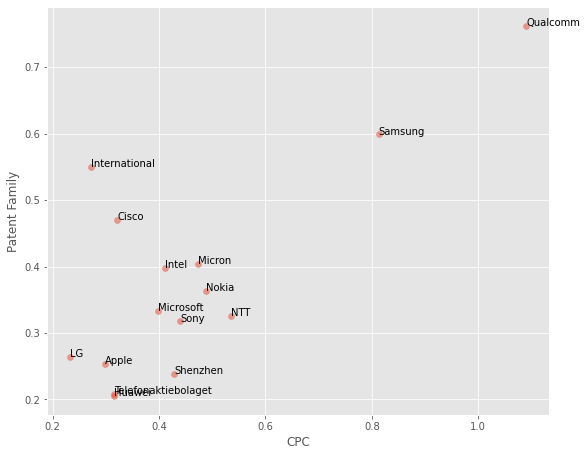

In [272]:
plt.figure(figsize=(9,7.5))
plt.style.use('ggplot')

plt.scatter(c_df.cpc, c_df.country, alpha=0.5)
plt.xlabel("CPC")
plt.ylabel("Patent Family")

for i, txt in enumerate(c_df.index):
    plt.text(c_df.cpc[i], c_df.country[i],txt.split(" ")[0])
    
plt.show()

# Scatter Plot 3
- 全部

In [67]:
com_df2=com_df.copy()

In [68]:
com_df2.loc[len(com_df2)]=["all",33072,10.40644228192155]

In [69]:
com_df2

,company,count,count_log
0,Qualcomm Inc,8491,9.046762
1,Samsung Electronics Co Ltd,6337,8.754161
2,Intel Corp,3236,8.082093
3,Telefonaktiebolaget LM Ericsson AB,2488,7.819234
4,Huawei Technologies Co Ltd,2461,7.808323
5,LG Electronics Inc,1931,7.565793
6,International Business Machines Corp,1591,7.372118
7,Apple Inc,1104,7.006695
8,Cisco Technology Inc,1092,6.995766
9,Microsoft Technology Licensing LLC,963,6.870053


In [70]:
ccontry_all = ccontry.loc[com_ls,:].copy()
ccontry_all.loc["all"] = list(ccontry_all.apply(lambda x: sum(x),axis=0))
ccontry_all

,AP,AR,AT,AU,BE,BG,BR,CA,CH,CL,...,SI,SM,TN,TR,TW,UA,US,UY,WO,ZA
company,,,,,,,,,,,,,,,,,,,,,
Qualcomm Inc,0.0,14.0,0.0,528.0,0.0,0.0,1328.0,532.0,0.0,57.0,...,12.0,0.0,8.0,0.0,2153.0,0.0,8345.0,0.0,7747.0,17.0
Samsung Electronics Co Ltd,0.0,0.0,0.0,147.0,0.0,0.0,9.0,34.0,0.0,0.0,...,0.0,0.0,0.0,0.0,217.0,0.0,6175.0,0.0,3438.0,0.0
Intel Corp,0.0,0.0,0.0,9.0,0.0,0.0,60.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,167.0,0.0,3254.0,0.0,1546.0,0.0
Telefonaktiebolaget LM Ericsson AB,2.0,182.0,0.0,136.0,0.0,0.0,348.0,140.0,0.0,21.0,...,0.0,0.0,0.0,7.0,61.0,0.0,2331.0,0.0,2436.0,139.0
Huawei Technologies Co Ltd,0.0,2.0,0.0,75.0,0.0,0.0,204.0,81.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1341.0,0.0,2117.0,4.0
LG Electronics Inc,0.0,1.0,0.0,31.0,0.0,0.0,25.0,16.0,0.0,12.0,...,0.0,0.0,0.0,0.0,10.0,0.0,1859.0,0.0,1294.0,1.0
International Business Machines Corp,0.0,0.0,0.0,1.0,0.0,0.0,2.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1687.0,0.0,142.0,2.0
Apple Inc,0.0,0.0,0.0,8.0,0.0,0.0,18.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,62.0,0.0,1045.0,0.0,1013.0,0.0
Cisco Technology Inc,0.0,0.0,0.0,13.0,0.0,0.0,0.0,54.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1160.0,0.0,326.0,0.0


In [71]:
ccontry_pcb_all = ccontry_all.apply(lambda x: x/sum(x), axis=1) #比例 row(axis=1)加總為1
ccontry_pcb_all["sum"] = ccontry_pcb_all.apply(lambda x: PCB(ccontry_pcb_all.loc["all",:],x), axis=1)

In [72]:
pcb_ls=[]

for i in ccontry_pcb_all.index:
    pcb = ccontry_pcb_all.loc[[i],:]["sum"].values+(com_df2.count_log[com_df2.company=="all"].values-com_df2.count_log[com_df2.company==i].values)**2
    pcb_ls.append(pcb[0])
    
ccontry_pcb_all["pcb"]=pcb_ls

In [73]:
ccontry_pcb_all

,AP,AR,AT,AU,BE,BG,BR,CA,CH,CL,...,TN,TR,TW,UA,US,UY,WO,ZA,sum,pcb
company,,,,,,,,,,,,,,,,,,,,,
Qualcomm Inc,0.000000,0.000397,0.0,0.014962,0.0,0.0,0.037632,0.015076,0.0,0.001615,...,0.000227,0.000000,0.061011,0.0,0.236476,0.0,0.219530,0.000482,0.158672,2.007403
Samsung Electronics Co Ltd,0.000000,0.000000,0.0,0.006181,0.0,0.0,0.000378,0.001430,0.0,0.000000,...,0.000000,0.000000,0.009124,0.0,0.259628,0.0,0.144551,0.000000,0.166404,2.896438
Intel Corp,0.000000,0.000000,0.0,0.001009,0.0,0.0,0.006723,0.000448,0.0,0.000000,...,0.000000,0.000000,0.018714,0.0,0.364635,0.0,0.173241,0.000000,0.177056,5.579654
Telefonaktiebolaget LM Ericsson AB,0.000166,0.015076,0.0,0.011266,0.0,0.0,0.028827,0.011597,0.0,0.001740,...,0.000000,0.000580,0.005053,0.0,0.193091,0.0,0.201789,0.011514,0.146153,6.839798
Huawei Technologies Co Ltd,0.000000,0.000249,0.0,0.009330,0.0,0.0,0.025376,0.010076,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.166812,0.0,0.263341,0.000498,0.174032,6.924255
LG Electronics Inc,0.000000,0.000169,0.0,0.005237,0.0,0.0,0.004224,0.002703,0.0,0.002027,...,0.000000,0.000000,0.001689,0.0,0.314073,0.0,0.218618,0.000169,0.175053,8.244340
International Business Machines Corp,0.000000,0.000000,0.0,0.000433,0.0,0.0,0.000867,0.000433,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.730936,0.0,0.061525,0.000867,0.221396,9.428520
Apple Inc,0.000000,0.000000,0.0,0.001978,0.0,0.0,0.004450,0.000494,0.0,0.000000,...,0.000000,0.000000,0.015328,0.0,0.258344,0.0,0.250433,0.000000,0.177627,11.735907
Cisco Technology Inc,0.000000,0.000000,0.0,0.006523,0.0,0.0,0.000000,0.027095,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.582037,0.0,0.163573,0.000000,0.217016,11.849727


In [74]:
ccpc

,A01,A21,A22,A23,A24,A41,A42,A43,A44,A45,...,G16,G21,H01,H02,H03,H04,H05,Y02,Y04,Y10
company,,,,,,,,,,,,,,,,,,,,,
#glowontech,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
(c-Dot),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,16.0,0.0,0.0,0.0,0.0
01 Bulletin Laboratory Co,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0
01 COMMUNIQUE LABORATORY Inc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0
0Chain LLC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
incNETWORKS Inc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,31.0,0.0,0.0,0.0,0.0
mSignia Inc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0
nChain Holdings Ltd,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,138.0,0.0,0.0,0.0,0.0


In [75]:
# ccpc.set_index("company", inplace=True)
ccpc_all = ccpc.loc[com_ls,:].copy()
ccpc_all.loc["all"] = list(ccpc_all.apply(lambda x: sum(x),axis=0))

In [76]:
ccpc_all2 = ccpc_all.apply(lambda x: x/sum(x), axis=1) #比例 row(axis=1)加總為1

# ccpc_pcb_ibm = ccpc2.loc[com_ls,:].copy()
ccpc_all2["sum"] = ccpc_all2.apply(lambda x: PCB(ccpc_all2.loc["all",:],x), axis=1)

In [77]:
ccpc_all2

,A01,A21,A22,A23,A24,A41,A42,A43,A44,A45,...,G21,H01,H02,H03,H04,H05,Y02,Y04,Y10,sum
company,,,,,,,,,,,,,,,,,,,,,
Qualcomm Inc,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000011,0.000000,...,0.0,0.027181,0.000976,0.017746,0.895970,0.001837,0.008356,0.000287,0.000000,0.609196
Samsung Electronics Co Ltd,0.000000,0.0,0.0,0.000027,0.000000,0.000135,0.000014,0.000122,0.000243,0.000635,...,0.0,0.061415,0.013321,0.015469,0.511531,0.012415,0.009308,0.000405,0.000230,0.384074
Intel Corp,0.000427,0.0,0.0,0.000000,0.000000,0.000152,0.000000,0.000091,0.000000,0.000000,...,0.0,0.108724,0.011915,0.013408,0.471676,0.007283,0.014596,0.001006,0.000061,0.368426
Telefonaktiebolaget LM Ericsson AB,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.003385,0.000564,0.011566,0.919544,0.001016,0.012130,0.000621,0.000000,0.624779
Huawei Technologies Co Ltd,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.007350,0.000817,0.013476,0.901762,0.000992,0.014409,0.000233,0.000000,0.615068
LG Electronics Inc,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000132,0.000044,0.000000,0.000175,...,0.0,0.002325,0.001491,0.003334,0.618222,0.003115,0.008291,0.000307,0.000000,0.438017
International Business Machines Corp,0.001758,0.0,0.0,0.000000,0.000070,0.000070,0.000000,0.000000,0.000000,0.000000,...,0.0,0.078492,0.007455,0.002391,0.264594,0.001829,0.009917,0.002040,0.000141,0.252434
Apple Inc,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.002985,0.001357,0.004884,0.930361,0.000000,0.012119,0.000090,0.000000,0.631630
Cisco Technology Inc,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.004466,0.006597,0.001522,0.746575,0.003451,0.013701,0.004770,0.000101,0.532885


In [78]:
pcb_ls=[]

for i in ccpc_all2.index:
    pcb = ccpc_all2.loc[[i],:]["sum"].values+(com_df2.count_log[com_df2.company=="all"].values-com_df2.count_log[com_df2.company==i].values)**2
    pcb_ls.append(pcb[0])
#     print(ccpc_all.loc[[i],:]["sum"].values)
    
ccpc_all2["pcb"]=pcb_ls

In [79]:
c_df = pd.DataFrame((zip(list(ccpc_all2["pcb"]), list(ccontry_pcb_all["pcb"]))), columns = ['cpc', 'country'])
c_df.set_index(ccpc_all2.index, inplace=True)

In [80]:
c_df

,cpc,country
company,,
Qualcomm Inc,2.457926,2.007403
Samsung Electronics Co Ltd,3.114108,2.896438
Intel Corp,5.771025,5.579654
Telefonaktiebolaget LM Ericsson AB,7.318423,6.839798
Huawei Technologies Co Ltd,7.365291,6.924255
LG Electronics Inc,8.507303,8.244340
International Business Machines Corp,9.459558,9.428520
Apple Inc,12.189910,11.735907
Cisco Technology Inc,12.165597,11.849727


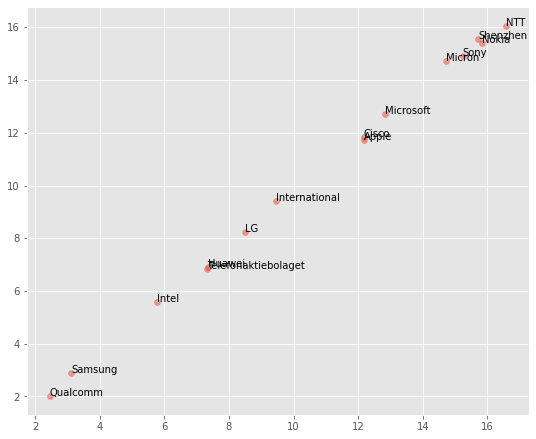

In [81]:
c_df2 = c_df.drop(["all"])

plt.figure(figsize=(9,7.5))
plt.style.use('ggplot')

plt.scatter(c_df2.cpc, c_df2.country, alpha=0.5)

for i, txt in enumerate(c_df2.index):
    plt.text(c_df2.cpc[i], c_df2.country[i],txt.split(" ")[0])
    
plt.show()